In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [107]:
df = pd.read_csv("https://raw.githubusercontent.com/Premalatha-success/Datasets/main/TaxiFare.csv")

In [108]:
df1=df

In [109]:
df.head()

,unique_id,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [110]:
df.shape

(50000, 8)

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   unique_id             50000 non-null  object 
 1   amount                50000 non-null  float64
 2   date_time_of_pickup   50000 non-null  object 
 3   longitude_of_pickup   50000 non-null  float64
 4   latitude_of_pickup    50000 non-null  float64
 5   longitude_of_dropoff  50000 non-null  float64
 6   latitude_of_dropoff   50000 non-null  float64
 7   no_of_passenger       50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


In [112]:
df.describe()

,amount,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734372,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


In [113]:
df.isnull().sum()

unique_id               0
amount                  0
date_time_of_pickup     0
longitude_of_pickup     0
latitude_of_pickup      0
longitude_of_dropoff    0
latitude_of_dropoff     0
no_of_passenger         0
dtype: int64

In [114]:
#Function to get distance in kilomerters using pickup and dropoff longitudes and latitudes using haversine formula
def haversine(lat1, lon1, lat2, lon2):

  # convert decimal degrees to radians
  lon1=np.deg2rad(lon1.to_numpy())
  lat1=np.deg2rad(lat1.to_numpy())
  lon2=np.deg2rad(lon2.to_numpy())
  lat2=np.deg2rad(lat2.to_numpy())

  # haversine formula
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
  c = 2 * np.arcsin(np.sqrt(a))
  r = 6372.8 # Radius of earth in kilometers
  return np.around(c * r, decimals=2)

In [115]:
#Adding New Features Using 'date_time_of_pickup' column
df['date_time_of_pickup'] = pd.to_datetime(df["date_time_of_pickup"])
df['year'] = df['date_time_of_pickup'].dt.year
df['month'] = df['date_time_of_pickup'].dt.month
df['date'] = df['date_time_of_pickup'].dt.day
df['day'] = df['date_time_of_pickup'].dt.dayofweek
df['hours'] = df['date_time_of_pickup'].dt.hour
df.drop('date_time_of_pickup',axis = 1,inplace = True)
df.drop('unique_id',axis = 1,inplace = True)

# Adding peak_hours as [18,19,20]
df['peak_hours'] = df['hours'].apply(lambda x: 1 if x in [18,19,20] else 0)


#Adding 'distance_travelled' column extracted using haversine function
df['distance_travelled'] = haversine(df['latitude_of_pickup'],df['longitude_of_pickup'],\
                                            df['latitude_of_dropoff'],df['longitude_of_dropoff'])

In [116]:
df.head()

,amount,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,year,month,date,day,hours,peak_hours,distance_travelled
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17,0,1.03
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16,0,8.45
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0,0,1.39
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4,0,2.80
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7,0,2.00


In [117]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   amount                50000 non-null  float64
 1   longitude_of_pickup   50000 non-null  float64
 2   latitude_of_pickup    50000 non-null  float64
 3   longitude_of_dropoff  50000 non-null  float64
 4   latitude_of_dropoff   50000 non-null  float64
 5   no_of_passenger       50000 non-null  int64  
 6   year                  50000 non-null  int64  
 7   month                 50000 non-null  int64  
 8   date                  50000 non-null  int64  
 9   day                   50000 non-null  int64  
 10  hours                 50000 non-null  int64  
 11  peak_hours            50000 non-null  int64  
 12  distance_travelled    50000 non-null  float64
dtypes: float64(6), int64(7)
memory usage: 5.0 MB


In [118]:
'''Function to Clean Following types of Messy data
1 - Drop Nan Value
2 - Drop negative,zero and fare amount over 200$
3 - Drop No of Passengers <= 0 and >= 7
4 - Drop outliers in longitudes,latitudes and distance
5 - Drop Key
'''
def clean_data(df):
    new_df = df[
        ((df['amount'] > 0) & (df['amount'] <= 200)) &
        ((df['longitude_of_pickup'] > -75) & (df['longitude_of_pickup'] < -73)) &
        ((df['latitude_of_pickup'] > 40) & (df['latitude_of_pickup'] < 42)) &
        ((df['longitude_of_dropoff'] > -75) & (df['longitude_of_dropoff'] < -73)) &
        ((df['latitude_of_dropoff'] > 40) & (df['latitude_of_dropoff'] < 42)) &
        ((df['no_of_passenger'] > 0) & (df['no_of_passenger'] <= 6)) &
        ((df['distance_travelled'] > 0) & (df['distance_travelled'] <= 200))

    ]
    return new_df

In [119]:
print("Length Before Cleaning: ",len(df))
df = clean_data(df)
print("Length After Cleaning: ",len(df))

Length Before Cleaning:  50000
Length After Cleaning:  48152


In [120]:
import seaborn as sns

<Axes: title={'center': 'Correlation Heatmap'}>

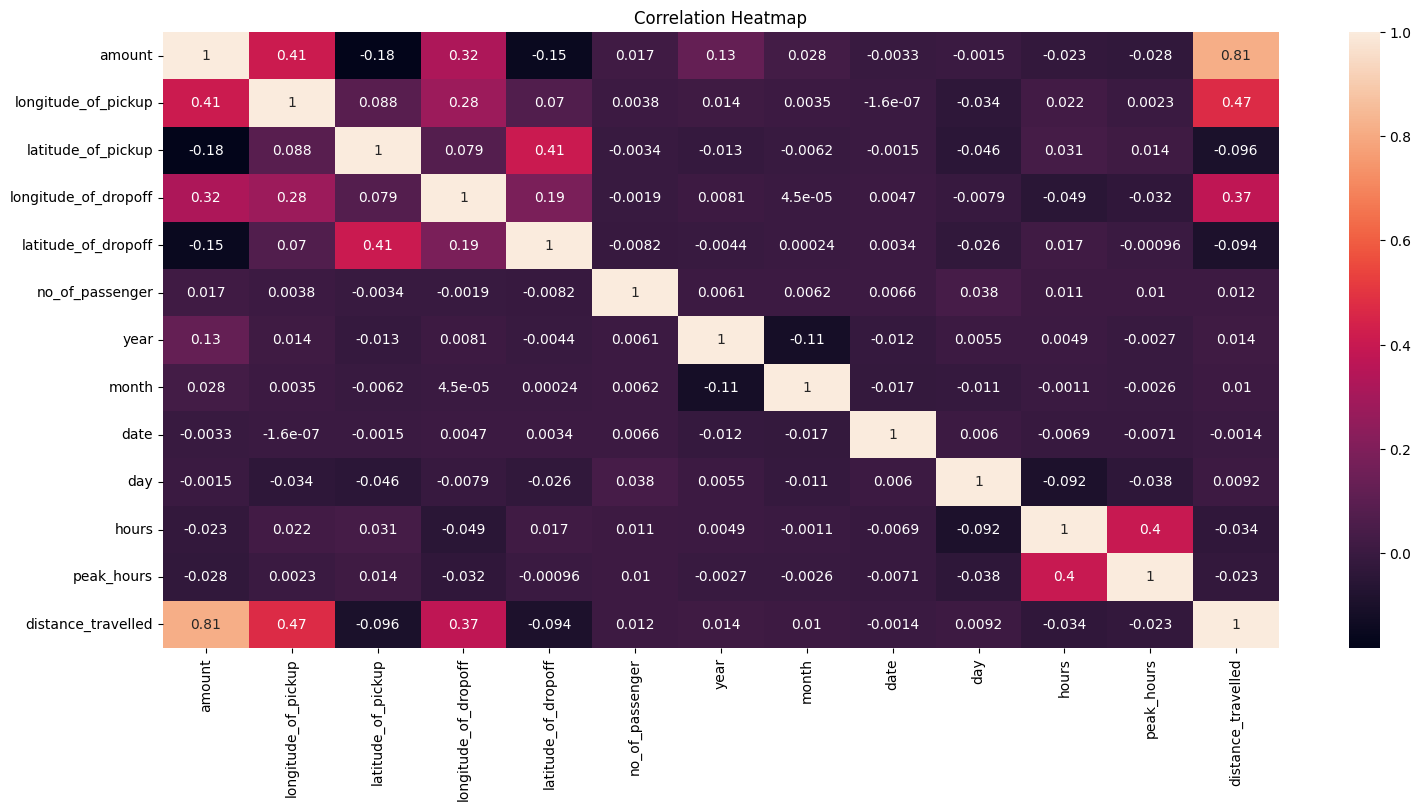

In [121]:
plt.figure(figsize = (18,8))
plt.title('Correlation Heatmap')
corr = df.corr()
corr
sns.heatmap(corr, annot = True)

In [122]:
#Splitting Data
df_x = df.drop(['amount'],axis = 1)
df_y = df['amount'].copy()

#Taking 20% data as Test data
x_train,x_test,y_train,y_test = train_test_split(df_x,df_y,test_size = 0.2,random_state = 42)

In [123]:
df_x.head()

,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,year,month,date,day,hours,peak_hours,distance_travelled
0,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17,0,1.03
1,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16,0,8.45
2,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0,0,1.39
3,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4,0,2.80
4,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7,0,2.00


In [124]:
results_df = pd.DataFrame(columns = ['Name','Mean Absolute Error','Root Mean Square Error'])

def results(name,prediction,test):
    global results_df
    #Mean Absolute Error
    print(name)
    mae = metrics.mean_absolute_error(test, prediction)
    print('Mean Absolute Error:', mae)

    #Root Mean Squared Error
    rmse = np.sqrt(metrics.mean_squared_error(test, prediction))
    print('Root Mean Squared Error:', rmse)

    results_df = results_df.append({'Name':name,"Mean Absolute Error":mae,"Root Mean Square Error":rmse},ignore_index = True)

In [125]:
scaler = StandardScaler()
model = linear_model.LinearRegression()
pipe = Pipeline(steps=[('scaler', scaler), ('model', model)], memory = 'tmp')

pipe.fit(x_train,y_train)
prediction1 = pipe.predict(x_test)

results("Linear Regression",prediction1,y_test)

Linear Regression
Mean Absolute Error: 2.533327600960087
Root Mean Squared Error: 5.1548698802393025


<ipython-input-124-aec1eacf2031>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Name':name,"Mean Absolute Error":mae,"Root Mean Square Error":rmse},ignore_index = True)


In [126]:
scaler = StandardScaler()
model = xgb.XGBRegressor(n_estimators = 200,learning_rate = 0.1,max_depth = 5)
pipe = Pipeline(steps=[('scaler', scaler), ('model', model)], memory = 'tmp')
pipe.fit(x_train,y_train)
prediction2 = pipe.predict(x_test)

results("XGBoost",prediction2,y_test)

XGBoost
Mean Absolute Error: 1.737197189264215
Root Mean Squared Error: 3.6381912999603574


<ipython-input-124-aec1eacf2031>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Name':name,"Mean Absolute Error":mae,"Root Mean Square Error":rmse},ignore_index = True)


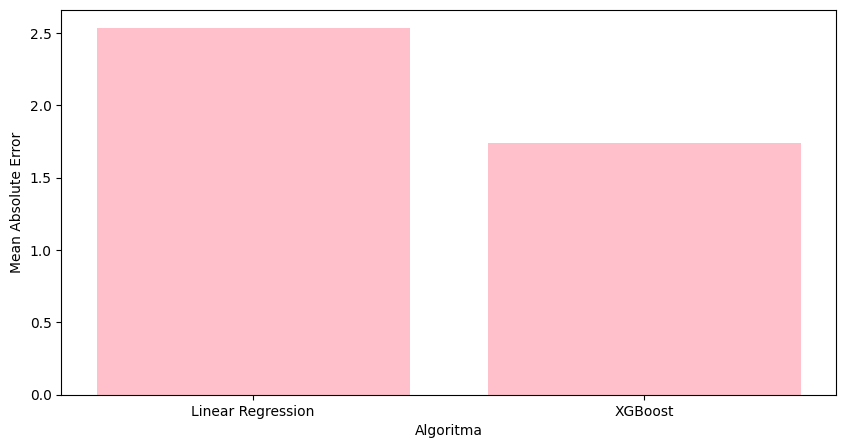

In [127]:
fig = plt.figure(figsize = (10,5))
plt.bar(results_df['Name'],results_df['Mean Absolute Error'],color = 'pink')
plt.xlabel('Algoritma')
plt.ylabel('Mean Absolute Error')
plt.show()

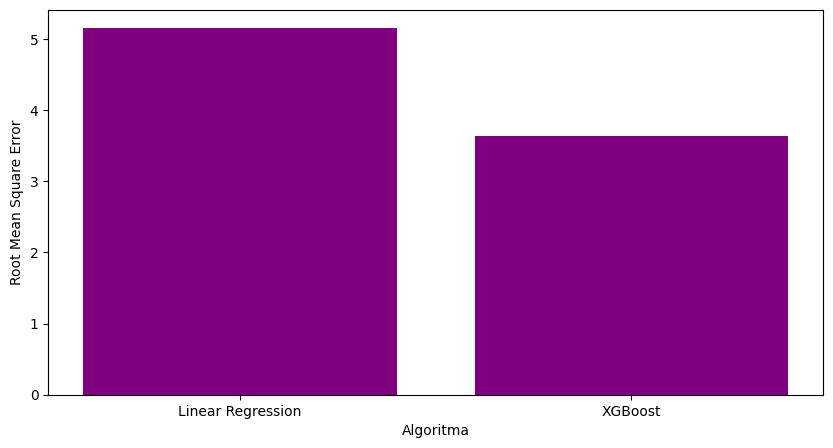

In [128]:
fig = plt.figure(figsize = (10,5))
plt.bar(results_df['Name'],results_df['Root Mean Square Error'],color = 'purple')
plt.xlabel('Algoritma')
plt.ylabel('Root Mean Square Error')
plt.show()